In [331]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import pandas as pd
import copy

from sklearn.metrics import roc_curve , roc_auc_score , precision_recall_curve, confusion_matrix , f1_score
from collections import Counter

pd.options.display.max_rows = 200

# Import Models and Test Data

In [332]:
rf = pickle.load(open('rf_final.p','rb'))
gb = pickle.load(open('gb_final.p','rb'))
logit= pickle.load(open('logRegModel.p','rb'))
vote_soft = pickle.load(open('voting_classifer_soft.p','rb'))

In [333]:
X_val = pickle.load(open('X_val_processed.p','rb'))
y_val = pickle.load(open('y_val.p','rb'))
X_test = pickle.load(open('X_test_processed.p','rb'))
y_test = pickle.load(open('y_test.p','rb'))


In [334]:
y_val.shape

(1069,)

# Build a ROC curve

In [335]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_fpr, vote_soft_tpr, vote_soft_thresholds = roc_curve(y_val,vote_soft.predict_proba(X_val)[:,1])



roc_auc_rf = roc_auc_score(y_val,rf.predict_proba(X_val)[:,1])
roc_auc_gb = roc_auc_score(y_val,gb.predict_proba(X_val)[:,1])
roc_auc_logistic = roc_auc_score(y_val,logit.predict_proba(X_val)[:,1])
roc_auc_vote_soft = roc_auc_score(y_val,vote_soft.predict_proba(X_val)[:,1])



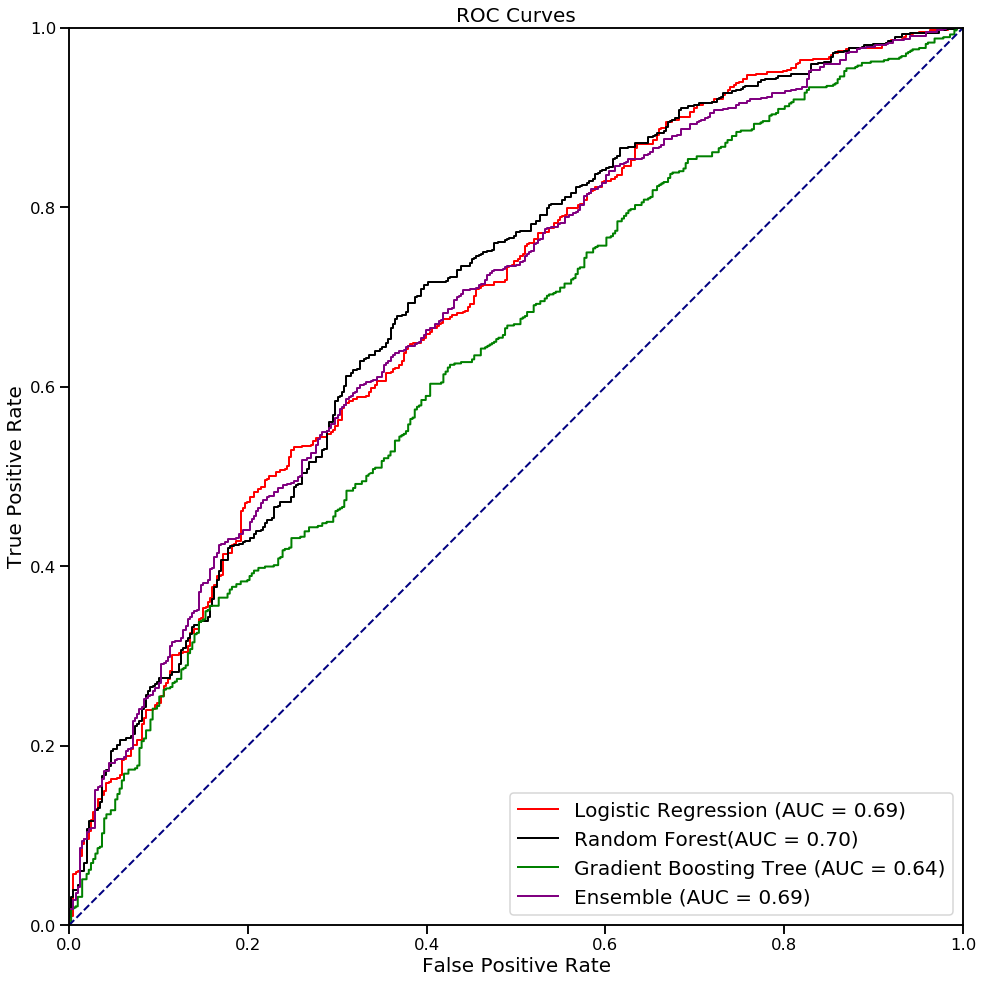

In [336]:
sns.set_context("talk")
fig = plt.figure(figsize=(14,14))
lw = 2


plt.plot(logit_fpr, logit_tpr, color='red',
         lw=lw, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logistic)
plt.plot(rf_fpr, rf_tpr, color='black',
         lw=lw, label='Random Forest(AUC = %0.2f)' % roc_auc_rf)
plt.plot(gb_fpr, gb_tpr, color='green',
         lw=lw, label='Gradient Boosting Tree (AUC = %0.2f)' % roc_auc_gb)
plt.plot(vote_soft_fpr,vote_soft_tpr, color='purple',
         lw=lw, label='Ensemble (AUC = %0.2f)' % roc_auc_vote_soft)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('ROC Curves', fontsize = 20)
plt.legend(loc="lower right", fontsize = 20)
plt.tight_layout()
# plt.savefig('roc_curves_all_ALL.png')
# plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

# Build a PR curve

In [337]:
rf_percision, rf_recall, rf_thresholds = precision_recall_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_percision, gb_recall, gb_thresholds = precision_recall_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_percision, logit_recall, logit_thresholds = precision_recall_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_percision, vote_soft_recall, vote_soft_thresholds = precision_recall_curve(y_val,vote_soft.predict_proba(X_val)[:,1])




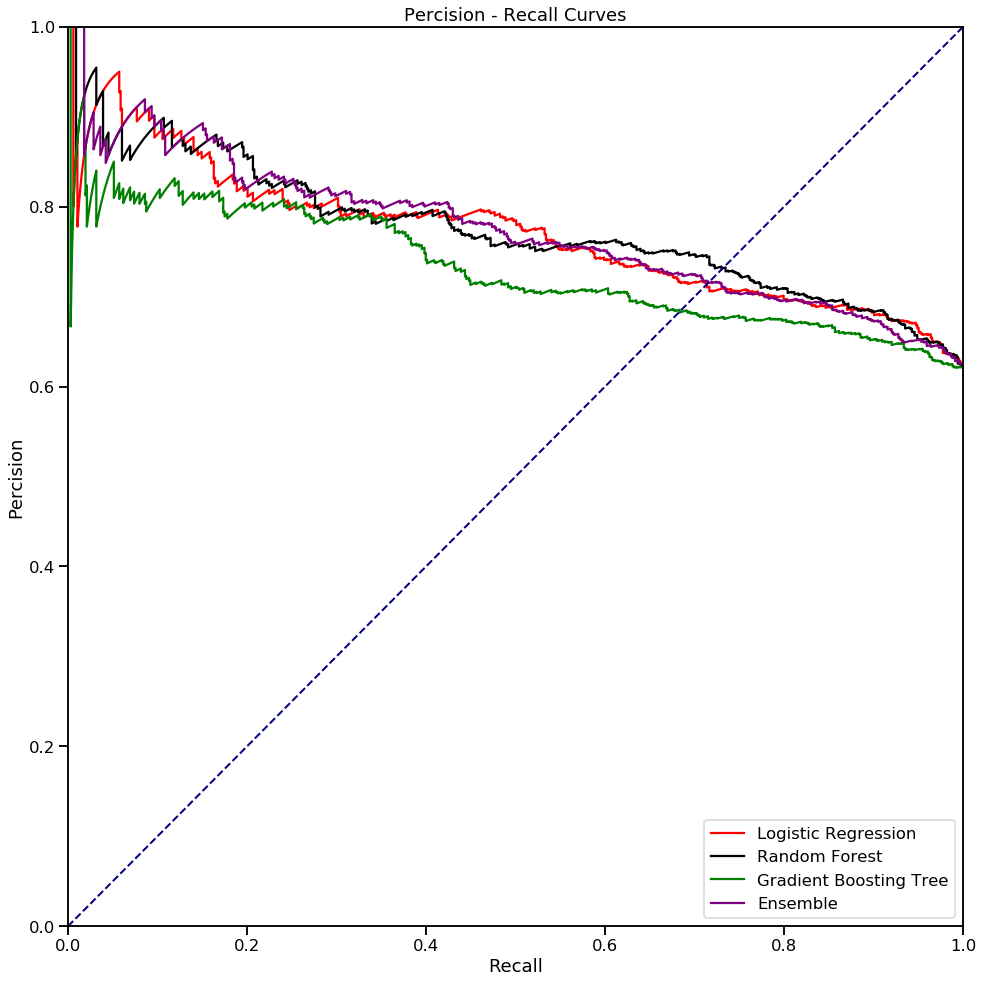

In [338]:
sns.set_context('talk')
fig = plt.figure(figsize=(14,14))



plt.plot( logit_recall,logit_percision, color='red',
          label='Logistic Regression')
plt.plot( rf_recall,rf_percision, color='black',
          label='Random Forest')
plt.plot( gb_recall,gb_percision, color='green',
          label='Gradient Boosting Tree')
plt.plot( vote_soft_recall,vote_soft_percision, color='purple',
          label='Ensemble')



plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Percision')
plt.title('Percision - Recall Curves')
plt.legend(loc="lower right")
plt.tight_layout()
# plt.savefig('roc_curves_all_ALL.png')
# plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

# Threshold Tuning 

In [339]:
threshold_tuner = pd.DataFrame({
    'y_val':y_val,
    'rf_prob':rf.predict_proba(X_val)[:,1],
    'gb_prob':gb.predict_proba(X_val)[:,1],
    'logit_prob':logit.predict_proba(X_val)[:,1],
    'ensemble_prob':vote_soft.predict_proba(X_val)[:,1]
})

In [340]:
threshold_tuner['threshold'] = 0 
threshold_tuner_exploded = pd.DataFrame(columns = threshold_tuner.columns)


for n in range(101):
    threshold_tuner['threshold'] = n/100
    threshold_tuner_exploded=threshold_tuner_exploded.append(threshold_tuner,ignore_index=True)

In [341]:

threshold_tuner_exploded['rf_fp'] = 0
threshold_tuner_exploded['rf_fn'] = 0



threshold_tuner_exploded['gb_fp'] = 0
threshold_tuner_exploded['gb_fn'] = 0



threshold_tuner_exploded['logit_fp'] = 0
threshold_tuner_exploded['logit_fn'] = 0



threshold_tuner_exploded['ensemble_fp'] = 0
threshold_tuner_exploded['ensemble_fn'] = 0


In [342]:
tte[tte.rf_prob<.50].sample(200)

y_val   rf_prob   gb_prob  logit_prob  ensemble_prob  threshold  rf_fp  \
18377      0  0.494709  0.006977    0.258740       0.246643       0.17      1   
2652       0  0.403218  0.356231    0.094361       0.178024       0.02      1   
12229      0  0.477378  0.001693    0.265148       0.265435       0.11      1   
26239      0  0.427129  0.000122    0.097162       0.187103       0.24      1   
40984      0  0.469369  0.118122    0.327468       0.275723       0.38      1   
16889      0  0.484829  0.015543    0.309875       0.255055       0.15      1   
87144      1  0.437414  0.011034    0.225823       0.232853       0.81      1   
2098       1  0.493775  0.001933    0.181943       0.223667       0.01      0   
85466      0  0.480596  0.003345    0.270812       0.258346       0.79      1   
98294      0  0.480596  0.003345    0.270812       0.258346       0.91      1   
101924     0  0.438127  0.000036    0.130983       0.185684       0.95      1   
62126      1  0.483267  0.002397    0.382748       0.607819       0.58      1   
84830      0  0.438062  0.015994    0.164989       0.198010       0.79      1   
57828      1  0.478034  0.696044    0.136111       0.209717       0.54      1   
80993      0  0.499529  0.038624    0.211078       0.229673       0.75      1   
53205      0  0.476350  0.008567    0.259169       0.251760       0.49      1   
105300     0  0.492273  0.022012    0.292352       0.279891       0.98      1   
56451      0  0.454006  0.004355    0.182446       0.213173       0.52      1   
89034      0  0.468586  0.000384    0.128930       0.198523       0.83      1   
31792      0  0.480597  0.005020    0.385819       0.298353       0.29      1   
83937      1  0.437414  0.011034    0.225823       0.232853       0.78      1   
9300       0  0.493716  0.070980    0.264560       0.317212       0.08      1   
83876      1  0.493436  0.806203    0.447802       0.627485       0.78      1   
43395      0  0.449867  0.002373    0.089037       0.182389       0.40      1   
43615      0  0.477514  0.003133    0.385613       0.310477       0.40      1   
62979      0  0.490431  0.017589    0.241810       0.256628       0.58      1   
87649      0  0.497621  0.167016    0.286414       0.589772       0.81      1   
81080      0  0.439315  0.001261    0.089393       0.176411       0.75      1   
84575      1  0.483267  0.002397    0.382748       0.607819       0.79      1   
50449      1  0.491047  0.262528    0.474674       0.634059       0.47      0   
52743      0  0.469369  0.118122    0.327468       0.275723       0.49      1   
37361      0  0.480596  0.003345    0.270812       0.258346       0.34      1   
80188      1  0.496382  0.345908    0.266566       0.598657       0.75      1   
104072     0  0.438062  0.015994    0.164989       0.198010       0.97      1   
38846      0  0.469369  0.118122    0.327468       0.275723       0.36      1   
49550      0  0.495845  0.503180    0.169949       0.230976       0.46      1   
71725      1  0.478034  0.696044    0.136111       0.209717       0.67      1   
42641      0  0.471101  0.053287    0.426157       0.311763       0.39      1   
30308      0  0.495845  0.503180    0.169949       0.230976       0.28      1   
91728      0  0.454006  0.004355    0.182446       0.213173       0.85      1   
35653      0  0.495845  0.503180    0.169949       0.230976       0.33      1   
33887      0  0.493716  0.070980    0.264560       0.317212       0.31      1   
76876      0  0.490431  0.017589    0.241810       0.256628       0.71      1   
86266      1  0.481982  0.996837    0.202181       0.567469       0.80      1   
74552      0  0.480597  0.005020    0.385819       0.298353       0.69      1   
25222      0  0.449867  0.002373    0.089037       0.182389       0.23      1   
34126      0  0.494954  0.031107    0.176730       0.283881       0.31      1   
101232     1  0.481982  0.996837    0.202181       0.567469       0.94      1   
76023      1  0.483267  0.002397    0.

In [343]:
tte=copy.deepcopy(threshold_tuner_exploded)

In [344]:
tte.loc[(tte.rf_prob>tte.threshold) & tte.y_val==0, 'rf_fp'] = int(1)
tte.loc[(tte.gb_prob>tte.threshold) & tte.y_val==0, 'gb_fp'] = int(1)
tte.loc[(tte.logit_prob>tte.threshold) & tte.y_val==0, 'logit_fp'] = int(1)
tte.loc[(tte.ensemble_prob>tte.threshold) & tte.y_val==0, 'ensemble_fp'] = int(1)

tte.loc[(tte.rf_prob<tte.threshold) & tte.y_val==1, 'rf_fn'] = int(1)
tte.loc[(tte.gb_prob<tte.threshold) & tte.y_val==1, 'gb_fn'] = int(1)
tte.loc[(tte.logit_prob<tte.threshold) & tte.y_val==1, 'logit_fn'] = int(1)
tte.loc[(tte.ensemble_prob<tte.threshold) & tte.y_val==1, 'ensemble_fn'] = int(1)

In [345]:
tte.head()

y_val   rf_prob   gb_prob  logit_prob  ensemble_prob  threshold  rf_fp  \
0     1  0.612254  0.910298    0.728733       0.577336        0.0      0   
1     1  0.677646  0.365279    0.787282       0.772959        0.0      0   
2     1  0.641392  0.987998    0.777093       0.816667        0.0      0   
3     0  0.542042  0.008091    0.305853       0.349071        0.0      1   
4     1  0.640004  0.478954    0.469313       0.670478        0.0      0   

   rf_fn  gb_fp  gb_fn  logit_fp  logit_fn  ensemble_fp  ensemble_fn  
0      0      0      0         0         0            0            0  
1      0      0      0         0         0            0            0  
2      0      0      0         0         0            0            0  
3      0      1      0         1         0            1            0  
4      0      0      0         0         0            0            0

In [346]:
tte['rf_cost'] = tte['rf_fp'] * 150000 + tte['rf_fn']*8000
tte['gb_cost'] = tte['gb_fp'] * 150000 + tte['gb_fn']*8000
tte['ensemble_cost'] = tte['ensemble_fp'] * 15000 + tte['ensemble_fn']*8000
tte['logit_cost'] = tte['logit_fp'] * 150000 + tte['logit_fn']*8000

In [347]:
tte.groupby(by= 'threshold').sum().sort_values(by= 'gb_cost', ascending = True)

rf_prob     gb_prob  logit_prob  ensemble_prob  rf_fp  rf_fn  \
threshold                                                                    
0.00       660.333253  711.825544   666.72282     690.509921    406      0   
0.01       660.333253  711.825544   666.72282     690.509921    406      0   
0.02       660.333253  711.825544   666.72282     690.509921    406      0   
0.03       660.333253  711.825544   666.72282     690.509921    406      0   
0.04       660.333253  711.825544   666.72282     690.509921    406      0   
0.05       660.333253  711.825544   666.72282     690.509921    406      0   
0.06       660.333253  711.825544   666.72282     690.509921    406      0   
0.07       660.333253  711.825544   666.72282     690.509921    406      0   
0.08       660.333253  711.825544   666.72282     690.509921    406      0   
0.09       660.333253  711.825544   666.72282     690.509921    406      0   
0.10       660.333253  711.825544   666.72282     690.509921    406      0   
0.11       660.333253  711.825544   666.72282     690.509921    406      0   
0.12       660.333253  711.825544   666.72282     690.509921    406      0   
0.13       660.333253  711.825544   666.72282     690.509921    406      0   
0.14       660.333253  711.825544   666.72282     690.509921    406      0   
0.15       660.333253  711.825544   666.72282     690.509921    406      0   
0.16       660.333253  711.825544   666.72282     690.509921    406      0   
0.17       660.333253  711.825544   666.72282     690.509921    406      0   
0.18       660.333253  711.825544   666.72282     690.509921    406      0   
0.19       660.333253  711.825544   666.72282     690.509921    406      0   
0.20       660.333253  711.825544   666.72282     690.509921    406      0   
0.21       660.333253  711.825544   666.72282     690.509921    406      0   
0.22       660.333253  711.825544   666.72282     690.509921    406      0   
0.23       660.333253  711.825544   666.72282     690.509921    406      0   
0.24       660.333253  711.825544   666.72282     690.509921    406      0   
0.25       660.333253  711.825544   666.72282     690.509921    406      0   
0.26       660.333253  711.825544   666.72282     690.509921    406      0   
0.27       660.333253  711.825544   666.72282     690.509921    406      0   
0.28       660.333253  711.825544   666.72282     690.509921    406      0   
0.29       660.333253  711.825544   666.72282     690.509921    406      0   
0.30       660.333253  711.825544   666.72282     690.509921    406      0   
0.31       660.333253  711.825544   666.72282     690.509921    406      0   
0.32       660.333253  711.825544   666.72282     690.509921    406      0   
0.33       660.333253  711.825544   666.72282     690.509921    406      0   
0.34       660.333253  711.825544   666.72282     690.509921    406      0   
0.35       660.333253  711.825544   666.72282     690.509921    406      0   
0.36       660.333253  711.825544   666.72282     690.509921    406      0   
0.38       660.333253  711.825544   666.72282     690.509921    406      0   
0.37       660.333253  711.825544   666.72282     690.509921    406      0   
0.39       660.333253  711.825544   666.72282     690.509921    406      0   
0.40       660.333253  711.825544   666.72282     690.509921    406      0   
0.41       660.333253  711.825544   666.72282     690.509921    406      0   
0.42       660.333253  711.825544   666.72282     690.509921    406      0   
0.43       660.333253  711.825544   666.72282     690.509921    406      0   
0.44       660.333253  711.825544   666.72282     690.509921    407      1   
0.45       660.333253  711.825544   666.72282     690.509921    407      1   
0.46       660.333253  711.825544   666.72282     690.509921    408      2   
0.47       660.333253  711.825544   666.72282     690.509921    410      4   
0.48       660.333253  711.825544   666.72282     690.509921    411      5   
0.49       660.333253  711.825544   

In [348]:
tte.groupby(by= 'threshold').sum().sort_values(by= 'ensemble_cost', ascending = True)

rf_prob     gb_prob  logit_prob  ensemble_prob  rf_fp  rf_fn  \
threshold                                                                    
0.00       660.333253  711.825544   666.72282     690.509921    406      0   
0.20       660.333253  711.825544   666.72282     690.509921    406      0   
0.19       660.333253  711.825544   666.72282     690.509921    406      0   
0.18       660.333253  711.825544   666.72282     690.509921    406      0   
0.17       660.333253  711.825544   666.72282     690.509921    406      0   
0.16       660.333253  711.825544   666.72282     690.509921    406      0   
0.15       660.333253  711.825544   666.72282     690.509921    406      0   
0.14       660.333253  711.825544   666.72282     690.509921    406      0   
0.13       660.333253  711.825544   666.72282     690.509921    406      0   
0.12       660.333253  711.825544   666.72282     690.509921    406      0   
0.11       660.333253  711.825544   666.72282     690.509921    406      0   
0.09       660.333253  711.825544   666.72282     690.509921    406      0   
0.08       660.333253  711.825544   666.72282     690.509921    406      0   
0.07       660.333253  711.825544   666.72282     690.509921    406      0   
0.06       660.333253  711.825544   666.72282     690.509921    406      0   
0.05       660.333253  711.825544   666.72282     690.509921    406      0   
0.04       660.333253  711.825544   666.72282     690.509921    406      0   
0.03       660.333253  711.825544   666.72282     690.509921    406      0   
0.02       660.333253  711.825544   666.72282     690.509921    406      0   
0.01       660.333253  711.825544   666.72282     690.509921    406      0   
0.10       660.333253  711.825544   666.72282     690.509921    406      0   
0.22       660.333253  711.825544   666.72282     690.509921    406      0   
0.21       660.333253  711.825544   666.72282     690.509921    406      0   
0.23       660.333253  711.825544   666.72282     690.509921    406      0   
0.24       660.333253  711.825544   666.72282     690.509921    406      0   
0.25       660.333253  711.825544   666.72282     690.509921    406      0   
0.26       660.333253  711.825544   666.72282     690.509921    406      0   
0.27       660.333253  711.825544   666.72282     690.509921    406      0   
0.28       660.333253  711.825544   666.72282     690.509921    406      0   
0.29       660.333253  711.825544   666.72282     690.509921    406      0   
0.30       660.333253  711.825544   666.72282     690.509921    406      0   
0.31       660.333253  711.825544   666.72282     690.509921    406      0   
0.32       660.333253  711.825544   666.72282     690.509921    406      0   
0.33       660.333253  711.825544   666.72282     690.509921    406      0   
0.34       660.333253  711.825544   666.72282     690.509921    406      0   
0.35       660.333253  711.825544   666.72282     690.509921    406      0   
0.36       660.333253  711.825544   666.72282     690.509921    406      0   
0.37       660.333253  711.825544   666.72282     690.509921    406      0   
0.38       660.333253  711.825544   666.72282     690.509921    406      0   
0.39       660.333253  711.825544   666.72282     690.509921    406      0   
0.40       660.333253  711.825544   666.72282     690.509921    406      0   
0.41       660.333253  711.825544   666.72282     690.509921    406      0   
0.42       660.333253  711.825544   666.72282     690.509921    406      0   
0.43       660.333253  711.825544   666.72282     690.509921    406      0   
0.44       660.333253  711.825544   666.72282     690.509921    407      1   
0.45       660.333253  711.825544   666.72282     690.509921    407      1   
0.46       660.333253  711.825544   666.72282     690.509921    408      2   
0.47       660.333253  711.825544   666.72282     690.509921    410      4   
0.48       660.333253  711.825544   666.72282     690.509921    411      5   
0.49       660.333253  711.825544   

In [349]:
f1_score(y_test,rf.predict(X_test))

0.77354900095147483

In [355]:
df_test1 = pd.DataFrame({'feauture':X_test.columns, 'importance':rf.feature_importances_}).sort_values(by= 'importance',ascending=False)

In [356]:
df_test2 = df_test1[df_test1.importance != 0]

In [360]:
df_test2.sort_values(by='importance',ascending = False)

feauture    importance
16763                               LearningCategoryWork  1.963550e-02
16762                      LearningCategoryOnlineCourses  1.396046e-02
16773                                 CompensationAmount  1.373884e-02
16760                                                Age  1.338151e-02
16767                                  TimeGatheringData  1.287630e-02
16768                                  TimeModelBuilding  1.276084e-02
16761                        LearningCategorySelftTaught  1.125084e-02
16770                                    TimeVisualizing  1.002376e-02
16769                                     TimeProduction  9.556935e-03
16771                                TimeFindingInsights  9.446334e-03
16764                         LearningCategoryUniversity  9.335175e-03
16752                      x44_Has increased 20% or more  9.224668e-03
80                                             x5_Poorly  9.092795e-03
22                                              x1_India  8.805005e-03
16754  x44_Has stayed about the same (has not increas...  8.478794e-03
87     x6_Employed by a company that performs advance...  8.388178e-03
16746                                          x43_Never  8.093302e-03
13721      x35_Enough to run the code / standard library  7.711076e-03
67                                     x4_Data Scientist  6.935674e-03
16765                             LearningCategoryKaggle  6.841911e-03
79                                          x5_Perfectly  6.785930e-03
82     x6_Employed by a company that doesn't perform ...  5.775942e-03
10108                               x33_Most of the time  5.722781e-03
6014                                           x29_Never  5.709660e-03
5763                              x22_Decreased slightly  5.406663e-03
16722  x42_Generic non-cloud file sharing software (E...  5.100553e-03
6013                                x29_Most of the time  4.976808e-03
16730                                            x42_Git  4.829981e-03
6015                                          x29_Rarely  4.721039e-03
5764                         x22_Increased significantly  4.709347e-03
5789                                  x25_Very important  4.701790e-03
16478                                  x39_IT Department  4.515109e-03
5791   x26_Analyze and understand data to influence p...  4.333445e-03
16742                                            x42_nan  4.224296e-03
16466                      x37_Less than 10% of projects  4.216655e-03
7033                                             x31_nan  4.138423e-03
13719  x35_Enough to explain the algorithm to someone...  3.864934e-03
5772                              x23_Less than one year  3.631645e-03
10112                                            x33_nan  3.463919e-03
5792   x26_Build and/or run a machine learning servic...  3.381437e-03
123    x6_Employed by professional services/consultin...  3.324088e-03
5753                        x21_10,000 or more employees  3.300643e-03
16748                                      x43_Sometimes  3.275026e-03
4113                              x16_University courses  3.267856e-03
16480                                x39_Standalone Team  3.201161e-03
16474                    x38_More internal than external  3.170848e-03
4110     x16_Online courses (coursera, udemy, edx, etc.)  3.124570e-03
16747                                         x43_Rarely  3.123900e-03
234                                            x9_Python  3.116761e-03
5766                                 x22_Stayed the same  3.095755e-03
3087                                 x12_Doctoral degree  3.031437e-03
3114                                x14_Less than a year  3.027790e-03
5765                              x22_Increased slightly  3.027521e-03
5723                             x19_A bachelor's degree  3.018565e-03
181                                            x7_Python  3.015323e-03
5784                                       x25_Important  3.003390e-03
1

In [358]:
df_test2.shape

(2265, 2)

In [351]:
f1_score(y_val,rf.predict(X_val))

0.77658303464755085

In [352]:
def predict_proba_output(X_val_proba, new_threshold):
    empty = []
    for values in X_val_proba[:,0]:
        if values <= new_threshold:
            empty.append(0)
        if values > new_threshold:
            empty.append(1)
    return(empty)

In [353]:
Counter(predict_proba_output(rf.predict_proba(X_val),.60))

Counter({0: 1068, 1: 1})

In [354]:
Counter(rf.predict(X_val))

Counter({1: 1011, 0: 58})

In [361]:
X_val

x0_A different identity  x0_Female  x0_Male  \
0                         0.0        0.0      1.0   
1                         0.0        0.0      1.0   
2                         0.0        0.0      1.0   
3                         0.0        0.0      1.0   
4                         0.0        0.0      1.0   
5                         0.0        0.0      1.0   
6                         0.0        0.0      1.0   
7                         1.0        0.0      0.0   
8                         0.0        0.0      1.0   
9                         0.0        0.0      1.0   
10                        0.0        0.0      1.0   
11                        0.0        1.0      0.0   
12                        0.0        0.0      1.0   
13                        0.0        0.0      1.0   
14                        0.0        0.0      1.0   
15                        0.0        0.0      1.0   
16                        0.0        0.0      1.0   
17                        0.0        0.0      1.0   
18                        0.0        0.0      1.0   
19                        0.0        1.0      0.0   
20                        0.0        0.0      1.0   
21                        0.0        0.0      1.0   
22                        0.0        0.0      1.0   
23                        0.0        0.0      1.0   
24                        0.0        0.0      1.0   
25                        0.0        1.0      0.0   
26                        0.0        0.0      1.0   
27                        0.0        0.0      1.0   
28                        0.0        0.0      1.0   
29                        0.0        0.0      1.0   
30                        0.0        0.0      1.0   
31                        0.0        0.0      1.0   
32                        0.0        0.0      1.0   
33                        0.0        1.0      0.0   
34                        0.0        0.0      1.0   
35                        0.0        0.0      1.0   
36                        0.0        0.0      1.0   
37                        0.0        0.0      1.0   
38                        0.0        0.0      1.0   
39                        0.0        0.0      1.0   
40                        0.0        0.0      1.0   
41                        0.0        0.0      1.0   
42                        0.0        1.0      0.0   
43                        0.0        0.0      1.0   
44                        0.0        0.0      1.0   
45                        0.0        1.0      0.0   
46                        0.0        0.0      1.0   
47                        0.0        0.0      1.0   
48                        0.0        0.0      1.0   
49                        0.0        0.0      1.0   
50                        0.0        0.0      1.0   
51                        0.0        0.0      1.0   
52                        0.0        0.0      1.0   
53                        0.0        1.0      0.0   
54                        0.0        0.0      1.0   
55                        0.0        1.0      0.0   
56                        0.0        0.0      1.0   
57                        0.0        0.0      1.0   
58                        0.0        0.0      1.0   
59                        0.0        0.0      1.0   
60                        0.0        0.0      1.0   
61                        0.0        0.0      1.0   
62                        0.0        0.0      1.0   
63                        0.0        0.0      1.0   
64                        0.0        0.0      1.0   
65                        0.0        0.0      1.0   
66                        0.0        1.0      0.0   
67                        0.0        0.0      1.0   
68                        0.0        0.0      1.0   
69                        0.0        0.0      1.0   
70                        0.0        0.0      1.0   
71                        0.0        0.0      1.0   
72                        0.0        0.0      1.0   
73                        0.0        0.0      1.0   
74                        0.0  